The time tensors should be exactly equal on cuda Heidelberg and cuda diffusers, but are not. Why?

**Edit (Solution):** The error was that `control_scale` are actualyl 2 concepts:
    a. scaling the connections strenght between base and control
    b. scaling the time mixture of base and control

Heidelberg set the former to `0.95`, but the latter to `1.0`. Introducing a time mixture parameter and setting it to `1.0` removes all error in time.

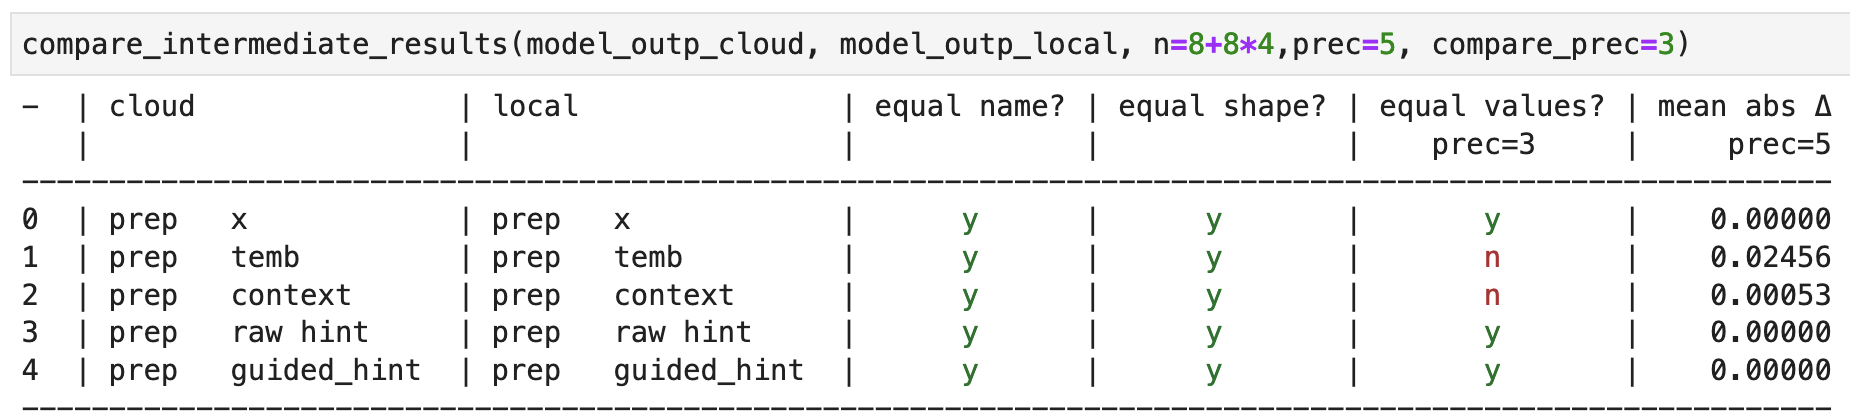

In [40]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3, sci_mode=False)

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Compare intermediate results

In [42]:
files = [
    'time__timestep_l.pt',
    'time__time_emb_l.pt',
    'time__time_proj_ctrl_l.pt',
    'time__time_proj_ctrl_scaled_l.pt',
    'time__time_proj_base_l.pt',
    'time__time_proj_base_scaled_l.pt',
    'time__time_proj_l.pt',
    'time__text_embeds_l.pt',
    'time__add_input_l.pt',
    'time__add_emb_l.pt',
    'time__add_proj_l.pt',
    'time__final_temb_l.pt',
]

In [43]:
# time information outputs from Heidelberg code run on cuda
time_c = [torch.load('intermediate_output/time emb/'+f.replace('_l','_c')).to(dtype=torch.float32) for f in files]
# time information outputs from diffusers code run on cuda
time_l = [torch.load('intermediate_output/time emb/'+f).to(dtype=torch.float32) for f in files]

len(time_c),len(time_l)

(12, 12)

In [44]:
# pre-embedding additional input wasn't available in Heidelberg code
time_c[8] = time_l[8]

time_l[0] = time_l[0].repeat(2)
for i in range(1,6+1):
    time_l[i] = time_l[i].repeat(2,1)

In [45]:
for i in range(len(files)):
    assert time_c[i].shape==time_l[i].shape
    print(time_c[i].shape)

torch.Size([2])
torch.Size([2, 320])
torch.Size([2, 1280])
torch.Size([2, 1280])
torch.Size([2, 1280])
torch.Size([2, 1280])
torch.Size([2, 1280])
torch.Size([2, 1280])
torch.Size([12])
torch.Size([2, 1536])
torch.Size([2, 1280])
torch.Size([2, 1280])


In [46]:
from torch.nn import L1Loss as mae

In [60]:
def tensor_head(t): return t.flatten()[:5]

print(f'{"":<3}{"name":<25}{"equal":<8}{"error":>6}\t{"cloud":^50}{"local":^55}')
for i in range(len(files)):
    c,l = time_c[i],time_l[i]
    eq = torch.allclose(c,l,atol=1e-3)
    err = (c-l).abs().mean()
    cv,lv = map(tensor_head, (c, l))
    name = files[i].replace('time__','').replace('_l.pt','')
    print(f'{i:<3}{name:<25}{str(eq):<8}{err:>6.2f}\t{str(cv):>50}{str(lv):>55}')

   name                     equal    error	                      cloud                                                local                         
0  timestep                 True      0.00	                              tensor([999., 999.])                                   tensor([999., 999.])
1  time_emb                 True      0.00	  tensor([ 1.000,  0.803, -0.278,  0.177, -0.278])       tensor([ 1.000,  0.803, -0.278,  0.177, -0.278])
2  time_proj_ctrl           True      0.00	  tensor([ 1.381, -3.744,  2.018, -1.710, -1.540])       tensor([ 1.381, -3.744,  2.018, -1.710, -1.540])
3  time_proj_ctrl_scaled    True      0.00	  tensor([ 1.381, -3.744,  2.018, -1.710, -1.540])       tensor([ 1.381, -3.744,  2.018, -1.710, -1.540])
4  time_proj_base           True      0.00	  tensor([-0.188,  0.114,  0.006,  0.115, -0.032])       tensor([-0.188,  0.114,  0.006,  0.115, -0.032])
5  time_proj_base_scaled    True      0.00	                    tensor([-0., 0., 0., 0., -0.])             

Interestingly, only 1 projection introduces error. `time_proj` introduces and error of ~ `0.02`, but `add_proj` doesn't.

Remember, `time_proj` is actually the linear interpolation (with `0.95**3`) of `ctrl_cloud_proj` and `base_cloud_proj`.

So, let's zoom into that.

**Edit:** The error was that `control_scale` are actualyl 2 concepts:
    a. scaling the connections strenght between base and control
    b. scaling the time mixture of base and control

Heidelberg set the former to `0.95`, but the latter to `1.0`. Introducing a time mixture parameter and setting it to `1.0` removes all error in time.